In [291]:
import geopandas as gpd
import numpy as np

In [292]:
zones = gpd.read_file('data/poznan/1POG_APP_04_IIKS.gml', layer='StrefaPlanistyczna')
apartment_zones = zones[zones['symbol'] == 'SW']
dense_apartment_zones = apartment_zones[apartment_zones['maksNadziemnaIntensywnoscZabudowy'] > 4]

In [293]:
# Read plots from GPKG file
plots_EGIB = gpd.read_file('data/poznan/EGIB_dzialki_poznan_2177.gpkg')
print(len(plots_EGIB), 'plots loaded')

118632 plots loaded


In [294]:
# Preprocess EGIB data

# 1. Remove very small and big plots
plots_EGIB['area'] = plots_EGIB.area
plots_EGIB = plots_EGIB[(plots_EGIB['area'] >= 200) & (plots_EGIB['area'] <= 6000)]
print(len(plots_EGIB), 'plots after size filter')

# 2. Remove not-central plots
central_districts = ['JEŻYCE', 'WILDA', 'ŁAZARZ']
plots_EGIB = plots_EGIB[plots_EGIB['NAZWA_OBREBU'].isin(central_districts)]
print(len(plots_EGIB), 'plots after central district filter')

"""
# 2. Remove plots not owned by the municipality
central_plots['GRUPA_REJESTROWA'] = central_plots['GRUPA_REJESTROWA'].fillna('')
target_values = ['4.1', '4.2', '4.3']
municipality_plots = central_plots[
    central_plots['GRUPA_REJESTROWA'].str.split(',').apply(
        lambda x: any(value.strip() in target_values for value in x if isinstance(x, list))
    )
]
print(len(municipality_plots), 'plots left after removing non-municipal plots')
"""
# 2. Remove plots with certain land use
invalid_uses = ['Wsr', 'W', 'Ls', 'Ba', 'Bz', 'dr', 'Tk', 'Ti', 'Tp', 'Wm', 'Wp', 'Ws']

plots_EGIB = plots_EGIB[plots_EGIB['OZNACZENIE_UZYTKU'].str.split(', ').apply(lambda uses: any(use in ['Bp', 'Bi'] for use in uses))]

print(len(plots_EGIB), 'plots after land use filter')

# 3. Remove plots with low shape index
plots_EGIB['shape_index'] = plots_EGIB.geometry.apply(lambda geom: 4 * np.pi * geom.area / (geom.length * geom.length))
plots_EGIB = plots_EGIB[plots_EGIB['shape_index'] > 0.3]
print(len(plots_EGIB), 'plots after shape index filter')

82642 plots after size filter
10129 plots after central district filter
1492 plots after land use filter
1354 plots after shape index filter


In [295]:
plots_EGIB.explore()

In [296]:
buildings_BDOT = gpd.read_file('data/poznan/PL.PZGiK.308.BDOT10k.3064__OT_BUBD_A.gpkg', mask=plots_EGIB)
buildings_BDOT.to_crs('EPSG:2177', inplace=True)
print(len(buildings_BDOT), ' buildings loaded that intersect with filtered plots')
irrelevant_functions = ['pozostałe budynki niemieszkalne', 'zbiorniki, silosy i budynki magazynowe', 'budynki produkcyjne, usługowe i gospodarcze dla rolnictwa']
important_buildings = buildings_BDOT[~buildings_BDOT['FUNKCJAOGOLNABUDYNKU'].isin(irrelevant_functions)]
print(len(important_buildings), 'buildings after function filter')
sized_buildings = important_buildings[important_buildings['geometry'].area > 70]
print(len(sized_buildings), 'buildings after size filter')


# Filter plots that don't intersect with buildings
spatial_join = gpd.sjoin(plots_EGIB, sized_buildings, how='left', predicate='intersects')
buildable_plots = plots_EGIB[~plots_EGIB.index.isin(spatial_join.index[spatial_join.index_right.notna()])]
print(len(buildable_plots), 'plots after building filter')

1606  buildings loaded that intersect with filtered plots
1224 buildings after function filter
1108 buildings after size filter
476 plots after building filter


In [297]:
buildable_plots['centroid'] = buildable_plots.geometry.centroid
buildable_plots.set_geometry('centroid', inplace=True)

/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [298]:

buildable_plots_plots_in_apartments_zones =  buildable_plots.sjoin(dense_apartment_zones, how='inner', predicate='within')
print(len(buildable_plots_plots_in_apartments_zones), 'plots in dense apartments zones')
#buildable_plots_plots_in_apartments_zones.set_geometry('geometry', inplace=True)
buildable_plots_plots_in_apartments_zones.explore()

59 plots in dense apartments zones


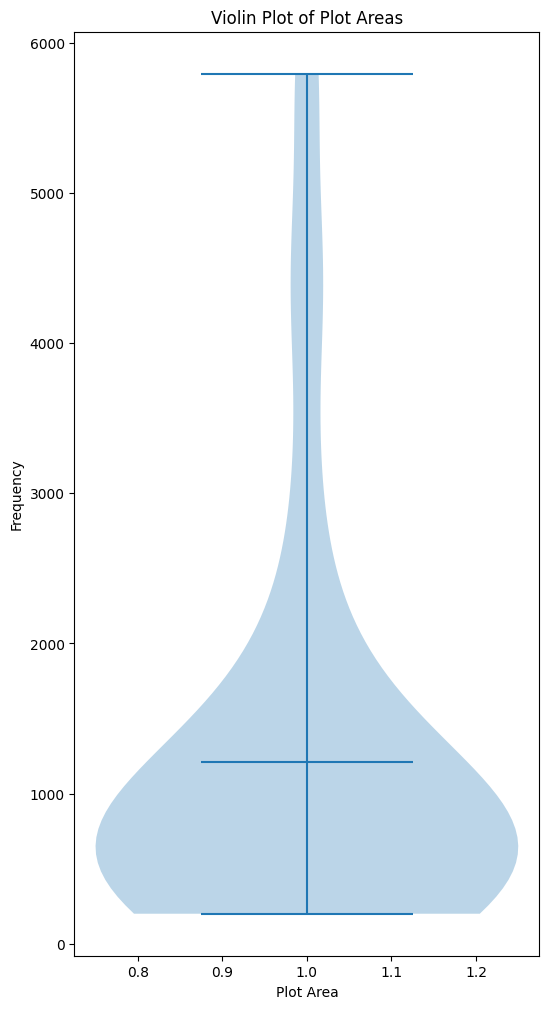

In [299]:
import matplotlib.pyplot as plt

# Create a violin plot of plot areas
plt.figure(figsize=(6, 12))
plt.violinplot(buildable_plots_plots_in_apartments_zones['area'], showmeans=True)
plt.xlabel('Plot Area')
plt.ylabel('Frequency')
plt.title('Violin Plot of Plot Areas')
plt.show()



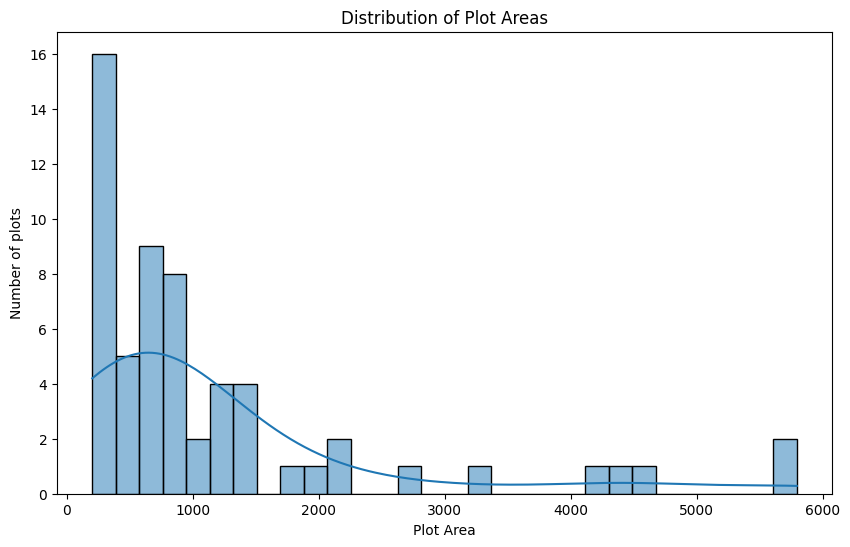

In [300]:
import seaborn as sns

# Create a distribution plot of plot areas
plt.figure(figsize=(10, 6))
sns.histplot(buildable_plots_plots_in_apartments_zones['area'], bins=30, kde=True)
plt.xlabel('Plot Area')
plt.ylabel('Number of plots')
plt.title('Distribution of Plot Areas')
plt.show()


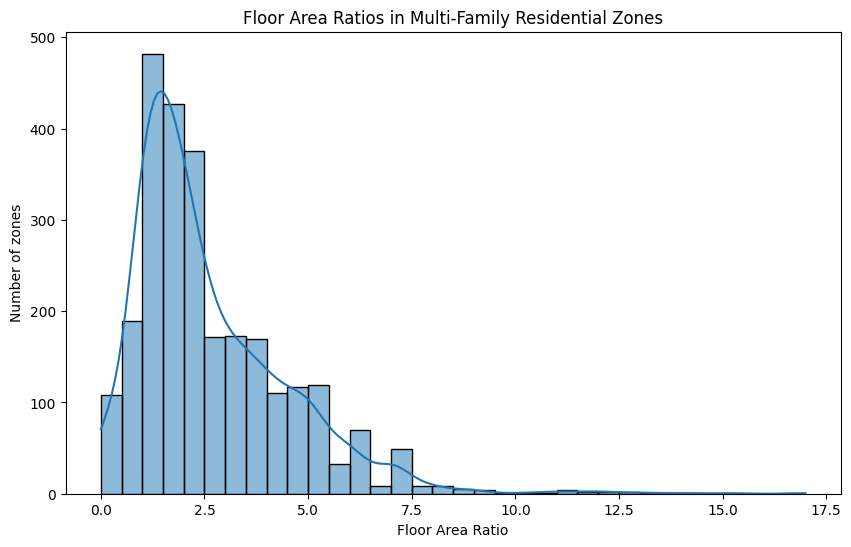

In [301]:
import seaborn as sns

# Create a distribution plot of plot areas
plt.figure(figsize=(10, 6))
sns.histplot(apartments_zones['maksNadziemnaIntensywnoscZabudowy'], bins=34, kde=True)
plt.xlabel('Floor Area Ratio')
plt.ylabel('Number of zones')
plt.title('Floor Area Ratios in Multi-Family Residential Zones')
plt.show()

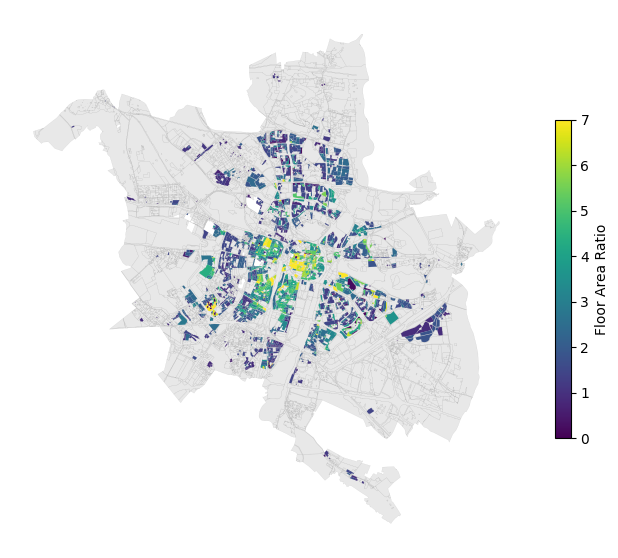

In [302]:
# Create a figure with A4 dimensions (8.27 x 11.69 inches)
plt.figure(figsize=(8.27, 8.27))

# First layer: All zones in gray
zones.plot(ax=plt.gca(), color='lightgray', edgecolor='gray', 
                    linewidth=0.1, alpha=0.5)

# Create a custom colormap for better differentiation of values
import matplotlib.colors as colors
norm = colors.Normalize(vmin=0, vmax=7)  # Adjust range based on your data
cmap = plt.cm.viridis

# Plot the truncated zones with viridis colormap
apartments_zones.plot(ax=plt.gca(), column='maksNadziemnaIntensywnoscZabudowy', 
                    cmap=cmap, norm=norm, legend=True, 
                    legend_kwds={'label': "Floor Area Ratio",
                                'orientation': "vertical",
                                'shrink': 0.5})

# Remove axes for a cleaner map
plt.axis('off')

# Save as high-resolution image
plt.savefig('building_intensity_zones.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()